<a href="https://colab.research.google.com/github/NelisLima/data_science/blob/main/5_machine_learning_deteccao_doencas_imagens_drones_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Projeto de Data Science - Machine Learning</font>

### Machine Learning Para Detecção de Doenças em Plantas Usando Imagens de Drones</font>

In [ ]:
# Imports

# Pacotes para manipulação e visualização de dados
import os
import cv2
import pickle
import imutils
import random
import sklearn
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from imutils import paths

# Pacotes para Deep Learning
import tensorflow as tf
import keras
from keras.models import load_model, save_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Pacotes para processamento de dados
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

# Define a área de plotagem das imagens
from IPython.display import clear_output
plt.rcParams['figure.figsize'] = (15, 9)
%matplotlib inline

In [ ]:
%env TF_CPP_MIN_LOG_LEVEL=3

env: TF_CPP_MIN_LOG_LEVEL=3


In [ ]:
# Imagens de treino
imagens_treino = "dados/dados/treino"

In [ ]:
# Imagens de teste
imagens_teste = "dados/dados/teste"

In [ ]:
# Caminho para as imagens
caminho_imagens_treino = sorted(list(paths.list_images(imagens_treino)))

In [ ]:
# Vamos randomizar os caminhos das imagens
random.shuffle(caminho_imagens_treino)

In [ ]:
# Vamos verificar uma amostra
caminho_imagens_treino[1:5]

['dados/dados/treino/ferrugem_do_tronco/YBGSNS.jpg',
 'dados/dados/treino/ferrugem_das_folhas/C65MAC.jpg',
 'dados/dados/treino/ferrugem_das_folhas/N5VHOY.jpg',
 'dados/dados/treino/ferrugem_das_folhas/VY0ZOQ.JPG']

### Processamento das Imagens
Agora carregamos as imagens, pré-processamos e armazenamos os arrays em uma lista de arrays.

In [ ]:
# Lista para armazenar as imagens (lista de arrays)
dados = []

In [ ]:
# Lista para armazenar os labels
labels = []

In [ ]:
# Dimensões das imagens
image_dims = (224, 224, 3)

In [ ]:
# Loop pelos caminhos das imagens de treino

print("\nIniciando o processamento das imagens de treino. Aguarde.")

count = 0

for caminho in caminho_imagens_treino:

    # Leitura da imagem
    image = cv2.imread(caminho)

    # Redimensionamento
    image = cv2.resize(image, (image_dims[1], image_dims[0]), cv2.INTER_AREA)

    # Converte a imagem para array numpy
    image = img_to_array(image)

    # Adiciona o array da imagem à lista de arrays
    dados.append(image)

    # Extrai o label das classes
    label = caminho.split(os.path.sep)[-2]

    # Adiciona o label à lista de labels
    labels.append(label)

    # Atualiza o contador
    count += 1

print("\nProcessamento Concluído. Total de imagens processadas:", count)


Iniciando o processamento das imagens de treino. Aguarde.

Processamento Concluído. Total de imagens processadas: 562


Esse aviso (warning) geralmente é causado por uma imagem PNG que foi criada ou exportada por uma ferramenta que não configurou corretamente o perfil de cores no arquivo. Isso não afeta necessariamente a imagem em termos de visualização, mas a libpng emite o aviso para indicar que os metadados da imagem não estão seguindo o padrão esperado.

In [ ]:
# Padronizamos a intensidade dos pixels para o range [0, 1]
dados = np.array(dados, dtype = "float") / 255.0

In [ ]:
# Convertemos os labels para o formato de array numpy
labels = np.array(labels)

In [ ]:
# Vamos imprimir o tamanho da lista de arrays
# Esse valor deve ser menor que o tamanho da memória RAM do computador.
# Caso contrário, terá problemas.
print("Tamanho da matriz de dados que contém as imagens: {:.2f}MB".format(dados.nbytes / (1024 * 1000.0)))

Tamanho da matriz de dados que contém as imagens: 660.91MB


Os labels estão no formato de texto. Precisamos binarizar os labels, convertendo texto para valores numéricos.

In [ ]:
# Amostra dos labels
labels[1:10]

array(['ferrugem_do_tronco', 'ferrugem_das_folhas', 'ferrugem_das_folhas',
       'ferrugem_das_folhas', 'ferrugem_das_folhas', 'ferrugem_do_tronco',
       'ferrugem_do_tronco', 'ferrugem_do_tronco', 'ferrugem_do_tronco'],
      dtype='<U19')

In [ ]:
# Criamos o binarizador
binarizador = LabelBinarizer()

In [ ]:
# Aplicamos o binarizador aos labels
labels = binarizador.fit_transform(labels)

In [ ]:
# Amostra dos labels
labels[1:10]

array([[0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]])

In [ ]:
# Vamos salvar o binarizador, pois precisaremos dele mais tarde para o deploy
obj_binarizador = open("dados/modelos/binarizador_dsa.pickle", "wb")
obj_binarizador.write(pickle.dumps(binarizador))
obj_binarizador.close()

Agora dividimos os dados em treino e teste. Observe que estamos dividindo o dataset de treino em treino e teste por causa dos labels. Os dados de teste fornecidos na fonte de dados não têm label e não podem ser usados para avaliar o modelo. Serão usados no deploy como novos dados.

In [ ]:
# Divisão dos dados em treino e teste
(X_treino, X_teste, y_treino, y_teste) = train_test_split(dados, labels, test_size = 0.2)

In [ ]:
# Shape
print("Shape de X_treino:", X_treino.shape)
print("Shape de y_treino:", y_treino.shape)
print("Shape de X_teste:", X_teste.shape)
print("Shape de y_teste:", y_teste.shape)

Shape de X_treino: (449, 224, 224, 3)
Shape de y_treino: (449, 3)
Shape de X_teste: (113, 224, 224, 3)
Shape de y_teste: (113, 3)


### Construção do Modelo

Vamos trabalhar com Deep Convolutional Network, usando Transferência de Aprendizado. Veja a descrição completa no videobook do Capítulo 19 do curso.

Nosso modelo base será o InceptionV3 pré-treinado e fornecido pelo Keras e sobre ele adicionaremos nossas camadas.

Referências:

https://keras.io/api/applications/inceptionv3/

http://www.deeplearningbook.com.br/

In [ ]:
# Função para construir o modelo
def cria_modelo(use_imagenet = True):

    # Carrega o modelo pré-treinado, mas sem as camadas finais, por isso include_top = False
    # As camadas finais adicionaremos ao modelo mais abaixo
    modelo_base = (keras.applications.InceptionV3(include_top = False,
                                                  input_shape = image_dims,
                                                  weights = 'imagenet' if use_imagenet else None))

    # Adcionamos a camada de Global Pooling
    novo_modelo = keras.layers.GlobalAveragePooling2D()(modelo_base.output)

    # Adicionamos a camada Densa de saída para nossas classes
    novo_modelo = keras.layers.Dense(len(binarizador.classes_), activation = 'softmax')(novo_modelo)

    # Concateamos tudo para gerar o modelo que será usado
    modelo = keras.Model(inputs = modelo_base.inputs, outputs = novo_modelo)

    return modelo

In [ ]:
# Inicializamos o modelo
modelo_final = cria_modelo()

In [ ]:
# Sumário do modelo
modelo_final.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 111, 111,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_94[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_94       │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 109, 109,  │      9,216 │ activation_94[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_95[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_95       │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 109, 109,  │     18,432 │ activation_95[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_96[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_96       │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 54, 54,    │          0 │ activation_96[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 54, 54,    │      5,120 │ max_pooling2d_4[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_97[0][0]   │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_97       │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 52, 52,    │    138,240 │ activation_97[0]… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_98[0][0]   │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_98       │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 21,808,931 (83.19 MB)

 Trainable params: 21,774,499 (83.06 MB)

 Non-trainable params: 34,432 (134.50 KB)

Vamos definir todas as camadas como "treináveis".

Veja a descrição no videobook do Capítulo 19 do curso.

In [ ]:
# Loop por todas as camadas do modelo
for layer in modelo_final.layers:

    # Camada treinável
    layer.trainable = True

    # Batch Normalization
    if isinstance(layer, keras.layers.BatchNormalization):
        layer.momentum = 0.7

In [ ]:
# Somente as últimas 50
for layer in modelo_final.layers[:-50]:

    # Se a camada não for de Batch Normalization não será treinável
    if not isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False

Estamos quase prontos. Vamos definir o checkpoint e um callback.

In [ ]:
# Caminho para salvar os checkpoints do modelo
caminho_modelo = "dados/modelos/modelo_dsa.keras"

In [ ]:
# Vamos monitorar o erro durante o treinamento e salvar sempre a melhor versão do modelo
checkpoint =  ModelCheckpoint(caminho_modelo,
                              monitor = "val_loss",
                              verbose = 1,
                              save_best_only = True,
                              mode = "min")

In [ ]:
# Vamos monitorar o erro durante o treinamento
# e interromper o treinamento se depois de 8 épocas o erro não diminuir
callback = EarlyStopping(monitor = 'val_loss',
                         mode = 'min',
                         verbose = 1,
                         patience = 8)

In [ ]:
# Lista de checkpoints
callbacks_list = [checkpoint, callback]

Precisamos compilar o modelo adicionando o otimizador, função de custo e a métrica.

In [ ]:
# Hiperparâmetros

# Número de épocas de treinamento
epochs = 25

# Taxa de aprendizado
taxa = 1e-3

# Batch size
batch = 32

In [ ]:
# Compila o modelo
modelo_final.compile(optimizer = Adam(learning_rate = taxa),
                     loss = 'categorical_crossentropy',
                     metrics = ["accuracy"])

E então treinamos o modelo.

In [ ]:
%%time

print("\nIniciando o treinamento do modelo. Aguarde.\n")

history = modelo_final.fit(X_treino, y_treino, batch_size = batch,
                           validation_data = (X_teste, y_teste),
                           epochs = epochs,
                           verbose = 1,
                           callbacks = callbacks_list)

print("\nTreinamento Concluído.\n")


Iniciando o treinamento do modelo. Aguarde.

Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.5318 - loss: 1.1117 
Epoch 1: val_loss improved from inf to 2.33630, saving model to dados/modelos/modelo_dsa.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 288s 14s/step - accuracy: 0.5382 - loss: 1.1066 - val_accuracy: 0.6903 - val_loss: 2.3363
Epoch 2/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.8918 - loss: 0.2609 
Epoch 2: val_loss improved from 2.33630 to 0.80885, saving model to dados/modelos/modelo_dsa.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 160s 11s/step - accuracy: 0.8928 - loss: 0.2593 - val_accuracy: 0.7345 - val_loss: 0.8089
Epoch 3/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9715 - loss: 0.1122 
Epoch 3: val_loss did not improve from 0.80885
15/15 ━━━━━━━━━━━━━━━━━━━━ 160s 11s/step - accuracy: 0.9714 - loss: 0.1116 - val_accuracy: 0.7345 - val_loss: 0.8499
Epoch 4/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9916 - loss: 0.0424 
Epoch 4: val_loss did 

### Avaliação do Modelo com Dados de Teste

Vamos carregar o modelo e o binarizador.

Como salvamos sempre o melhor modelo usaremos o último arquivo.

In [ ]:
# Carrega o modelo
modelo = load_model("dados/modelos/modelo_dsa.keras")

In [ ]:
# Carrega o binarizador
obj_bin = pickle.loads(open("dados/modelos/binarizador_dsa.pickle", "rb").read())

In [ ]:
# Previsões com os dados de teste
y_pred = modelo.predict(X_teste)

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step


In [ ]:
# Funções para as métricas
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# Converte y_pred para classes únicas
y_pred_classes = np.argmax(y_pred, axis = 1)

In [ ]:
# Converte y_teste para classes únicas
# Use isso apenas se y_teste estiver em formato one-hot, que é o nosso caso
y_teste_classes = np.argmax(y_teste, axis = 1)

In [ ]:
# Calcular a acurácia
accuracy = accuracy_score(y_teste_classes, y_pred_classes)
print("Acurácia:", accuracy)

Acurácia: 0.8053097345132744


In [ ]:
# Relatório de classificação
print(classification_report(y_teste_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.68      0.84      0.75        38
           1       0.89      0.84      0.86        56
           2       0.92      0.63      0.75        19

    accuracy                           0.81       113
   macro avg       0.83      0.77      0.79       113
weighted avg       0.82      0.81      0.81       113



### Deploy e Uso do Modelo com Novas Imagens

### Classificação de Nova Imagem - Teste 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


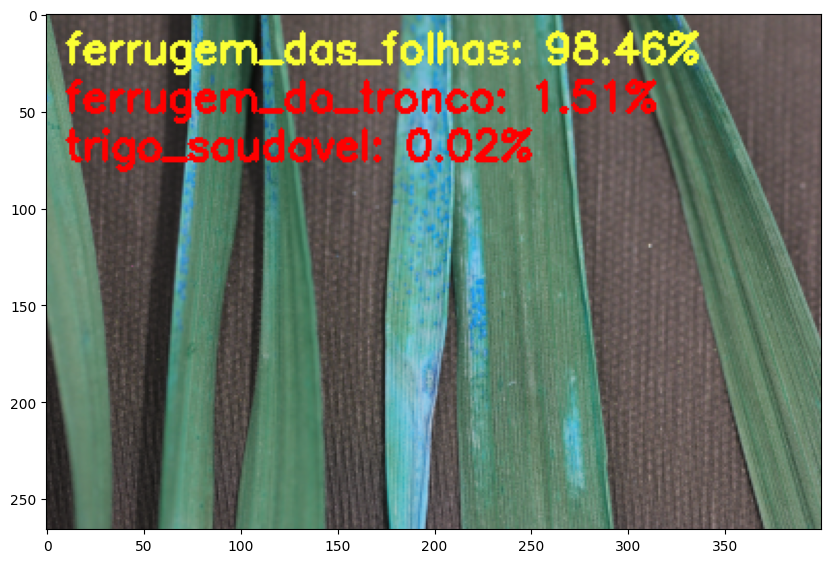

In [ ]:
# Obtemos uma imagem de teste de forma randômica
imagem_teste = random.choice(os.listdir(imagens_teste))

# Fazemos a leitura da imagem com OpenCV
imagem = cv2.imread(os.path.join(imagens_teste, imagem_teste))

# Vamos criar uma cópia da imagem, pois usaremos a imagem original mais tarde
imagem_copia = imagem.copy()

# Aplicamos na imagem de teste o mesmo pré-processamento aplicado nas imagens de treino
imagem = cv2.resize(imagem, (224, 224))
imagem = imagem.astype("float") / 255.0
imagem = img_to_array(imagem)
imagem = np.expand_dims(imagem, axis = 0)

# E então fazemos a previsão com o modelo, extraindo a probabilidade de classe
proba = modelo.predict(imagem)[0]

# Como queremos a classe prevista pelo modelo, obtemos o maior valor entre as 3 probabilidades
idx = np.argmax(proba)

# E aplicamos o binarizador ao label
label = obj_bin.classes_[idx]

# Vamos adicionar ao label a probabilidade
label = "{}: {:.2f}%".format(label, proba[idx] * 100)

# Altera o tamanho da imagem original para o Plot
imagem_copia = imutils.resize(imagem_copia, width = 400)

# Loop pelas probabilidades previstas pelo modelo e plot da imagem original e da previsão de classe e probabilidade
j = 0
for t in range(len(list(proba))):
    if t not in [idx]:
        label1 = obj_bin.classes_[t]
        label1 = "{}: {:.2f}%".format(label1, proba[t] * 100)
        cv2.putText(imagem_copia, label1, (10, 50 + j), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
        j = j + 25

# Plot
cv2.putText(imagem_copia, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (251, 255, 51), 2)
plt.figure(figsize = (10,10))
plt.imshow(imagem_copia)

### Classificação de Nova Imagem - Teste 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


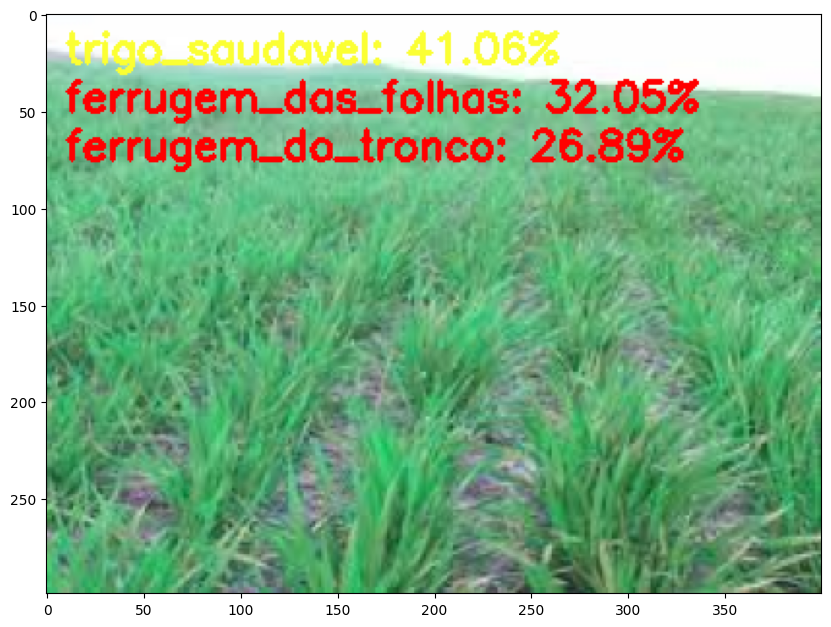

In [ ]:
# Obtemos uma imagem de teste de forma randômica
imagem_teste = random.choice(os.listdir(imagens_teste))

# Fazemos a leitura da imagem com OpenCV
imagem = cv2.imread(os.path.join(imagens_teste, imagem_teste))

# Vamos criar uma cópia da imagem, pois usaremos a imagem original mais tarde
imagem_copia = imagem.copy()

# Aplicamos na imagem de teste o mesmo pré-processamento aplicado nas imagens de treino
imagem = cv2.resize(imagem, (224, 224))
imagem = imagem.astype("float") / 255.0
imagem = img_to_array(imagem)
imagem = np.expand_dims(imagem, axis = 0)

# E então fazemos a previsão com o modelo, extraindo a probabilidade de classe
proba = modelo.predict(imagem)[0]

# Como queremos a classe prevista pelo modelo, obtemos o maior valor entre as 3 probabilidades
idx = np.argmax(proba)

# E aplicamos o binarizador ao label
label = obj_bin.classes_[idx]

# Vamos adicionar ao label a probabilidade
label = "{}: {:.2f}%".format(label, proba[idx] * 100)

# Altera o tamanho da imagem original para o Plot
imagem_copia = imutils.resize(imagem_copia, width = 400)

# Loop pelas probabilidades previstas pelo modelo e plot da imagem original e da previsão de classe e probabilidade
j = 0
for t in range(len(list(proba))):
    if t not in [idx]:
        label1 = obj_bin.classes_[t]
        label1 = "{}: {:.2f}%".format(label1, proba[t] * 100)
        cv2.putText(imagem_copia, label1, (10, 50 + j), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
        j = j + 25

# Plot
cv2.putText(imagem_copia, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (251, 255, 51), 2)
plt.figure(figsize = (10,10))
plt.imshow(imagem_copia)

### Classificação de Nova Imagem - Teste 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


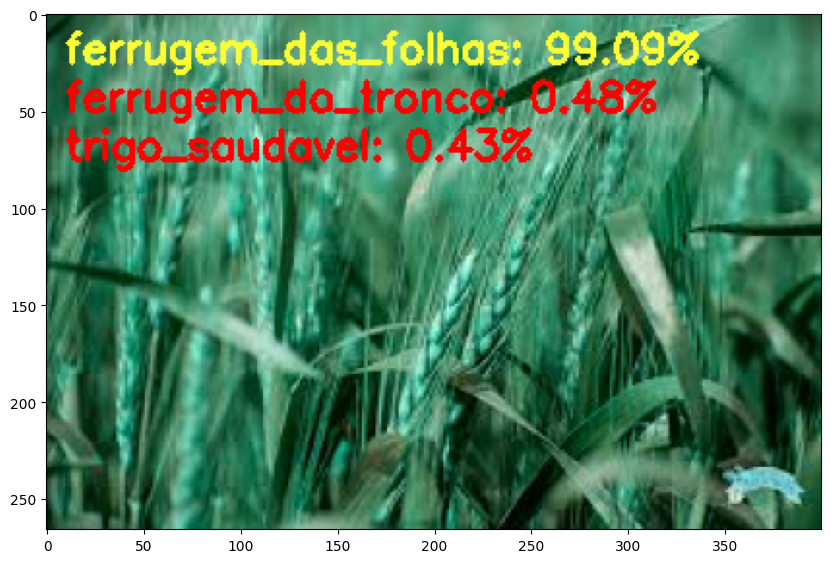

In [ ]:
# Obtemos uma imagem de teste de forma randômica
imagem_teste = random.choice(os.listdir(imagens_teste))

# Fazemos a leitura da imagem com OpenCV
imagem = cv2.imread(os.path.join(imagens_teste, imagem_teste))

# Vamos criar uma cópia da imagem, pois usaremos a imagem original mais tarde
imagem_copia = imagem.copy()

# Aplicamos na imagem de teste o mesmo pré-processamento aplicado nas imagens de treino
imagem = cv2.resize(imagem, (224, 224))
imagem = imagem.astype("float") / 255.0
imagem = img_to_array(imagem)
imagem = np.expand_dims(imagem, axis = 0)

# E então fazemos a previsão com o modelo, extraindo a probabilidade de classe
proba = modelo.predict(imagem)[0]

# Como queremos a classe prevista pelo modelo, obtemos o maior valor entre as 3 probabilidades
idx = np.argmax(proba)

# E aplicamos o binarizador ao label
label = obj_bin.classes_[idx]

# Vamos adicionar ao label a probabilidade
label = "{}: {:.2f}%".format(label, proba[idx] * 100)

# Altera o tamanho da imagem original para o Plot
imagem_copia = imutils.resize(imagem_copia, width = 400)

# Loop pelas probabilidades previstas pelo modelo e plot da imagem original e da previsão de classe e probabilidade
j = 0
for t in range(len(list(proba))):
    if t not in [idx]:
        label1 = obj_bin.classes_[t]
        label1 = "{}: {:.2f}%".format(label1, proba[t] * 100)
        cv2.putText(imagem_copia, label1, (10, 50 + j), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
        j = j + 25

# Plot
cv2.putText(imagem_copia, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (251, 255, 51), 2)
plt.figure(figsize = (10,10))
plt.imshow(imagem_copia)

Trabalho concluído! Deep Convolutional Networks são redes com alta precisão e usando Transferência de Aprendizado o tempo de treinamento é reduzido de forma drástica, aumentando a produtividade.